<a href="https://colab.research.google.com/github/tneumann/htw_cnn_lecture/blob/master/001_pytorch_intro_mnist_linear_classifier_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Pytorch - MNIST Digit Classification - Solution

 - Finish the training loop prepared below and train the network for 5 epochs. What accuracy do you achieve?
 - Bonus: Visualize some images from the validation set that are misclassified - what can you see?
 - Bonus: Instead of MNIST, try FashionMNIST, which has the same format but is much harder then MNIST

In [1]:
%matplotlib inline

# import numpy - array processing library
import numpy as np 

# pytorch imports:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch functionality for image datasets
from torchvision import datasets, transforms

# standard plotting library
import matplotlib.pyplot as plt



def show_image_grid(X, y=None, y_pred=None, title=None, nrow=6, ncol=4, **kwargs):
    max_num = nrow*ncol
    X = X[:max_num]
    if len(X) < max_num:
        ncol = len(X) // nrow + 1
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    if X.dim() != 4:
        X = X[:, None]

    plt.figure(title, figsize=(2*nrow, 2*ncol + (0 if y is None else 1)))
    if title:
        plt.suptitle(title)

    plt.gray()
        
    if isinstance(y, torch.Tensor):
        y = y.numpy()
        
    for i, Xi in enumerate(X):
        plt.subplot(ncol, nrow, i+1)
        img = Xi.numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:
            img = img[..., 0]
        plt.imshow(img)

        title = ""
        if y is not None:
          title += str(int(y[i]))
        if y_pred is not None:
          title += "/" + str(int(y_pred[i]))
        if len(title) > 0: 
          plt.title(title)

        plt.axis('off')
    
    plt.axis('off')

In [2]:
batch_size = 128
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_data = datasets.MNIST(root='./data', train=False, 
                            download=True, transform=transforms.ToTensor())
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)


def forward(X, weight, bias):
    return X.view(-1, 28*28) @ weight + bias

def accuracy(output, label):
    return (output.argmax(1) == label).float().mean()

lr = 0.1

# initialize weights
weight = torch.zeros((28*28, 10), requires_grad=True)
nn.init.kaiming_uniform_(weight, mode='fan_out')
bias = torch.zeros(10, requires_grad=True)

for epoch in range(5):

    losses = []
    ys = []
    outputs = []
    
    for Xb, yb in train_loader:
      ys.append(yb) # save to compute train accuracy

      # forward pass
      output = forward(Xb, weight, bias)
      outputs.append(output)

      # compute loss
      loss = F.cross_entropy(output, yb)
      losses.append(loss.item())

      loss.backward() # backpropagation

      # gradient descent update
      with torch.no_grad():
        weight -= lr * weight.grad
        weight.grad.zero_()
        bias -= lr * bias.grad
        bias.grad.zero_()

    train_acc = accuracy(torch.cat(outputs), torch.cat(ys))
            
    # measure accuracy on the validation set
    val_outputs = []
    val_y = []
    for Xb, yb in valid_loader:
      val_outputs.append(forward(Xb, weight, bias))
      val_y.append(yb)

    val_acc = accuracy(torch.cat(val_outputs), torch.cat(val_y))

    print("epoch % 5d: loss: % 8.5f accuracy: %6.3f val / %6.3f train" % (epoch, np.mean(losses), val_acc.item(), train_acc.item()))


epoch     0: loss:  0.57819 accuracy:  0.900 val /  0.855 train
epoch     1: loss:  0.37510 accuracy:  0.910 val /  0.897 train
epoch     2: loss:  0.34363 accuracy:  0.913 val /  0.904 train
epoch     3: loss:  0.32723 accuracy:  0.917 val /  0.909 train
epoch     4: loss:  0.31620 accuracy:  0.917 val /  0.912 train


After training, you can visualize predictions of digits from the validation set to check if they are correct:

In [3]:
y_pred = []
y_true = []
X = []
per_sample_loss = []

# loop over validation set in batches
for Xb, yb in valid_loader:

  # save all images (only do this for small datasets!)
  X.append(Xb)

  # pass this batch through the network
  output = forward(Xb, weight, bias)

  # compute the loss, for each example (therefore no reduction)
  per_sample_loss.append(F.cross_entropy(output, yb, reduction='none'))
  
  # save predicted and actual labels
  y_pred.append(output.argmax(dim=1))
  y_true.append(yb)

# concatenate all the lists to tensors
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)
X = torch.cat(X)
per_sample_loss = torch.cat(per_sample_loss)

X.shape, y_pred.shape, y_true.shape, per_sample_loss.shape

(torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]),
 torch.Size([10000]),
 torch.Size([10000]))

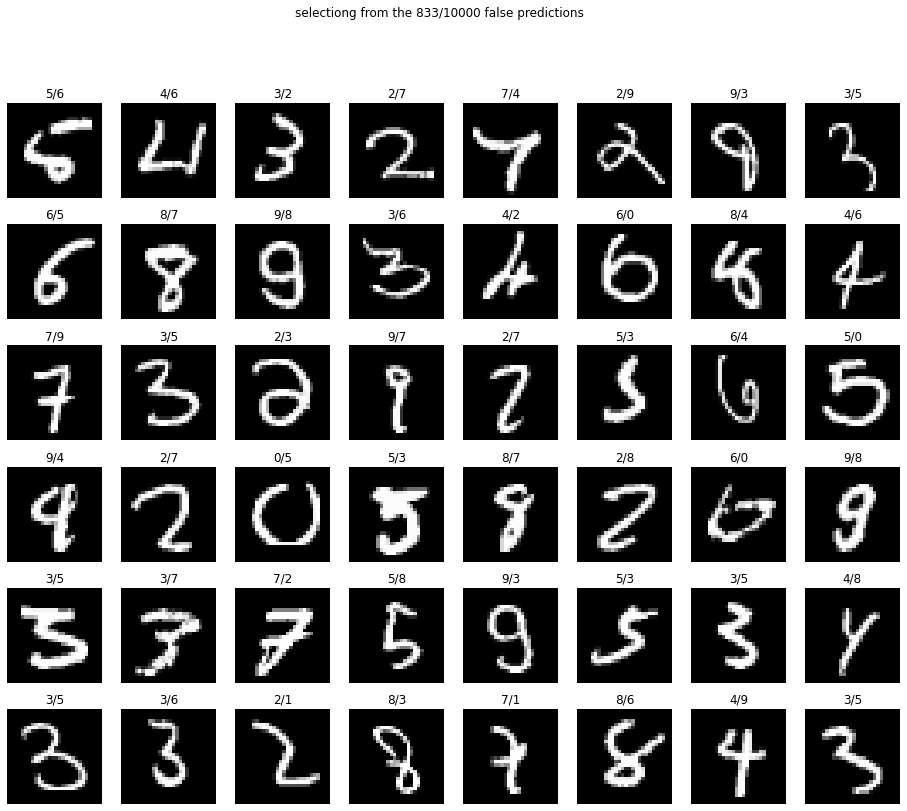

In [4]:
is_wrong = y_pred != y_true

show_image_grid(
    X[is_wrong], 
    y=y_true[is_wrong], 
    y_pred=y_pred[is_wrong], 
    title=f"selectiong from the {is_wrong.sum()}/{len(X)} false predictions",
    nrow=8, ncol=6,
)

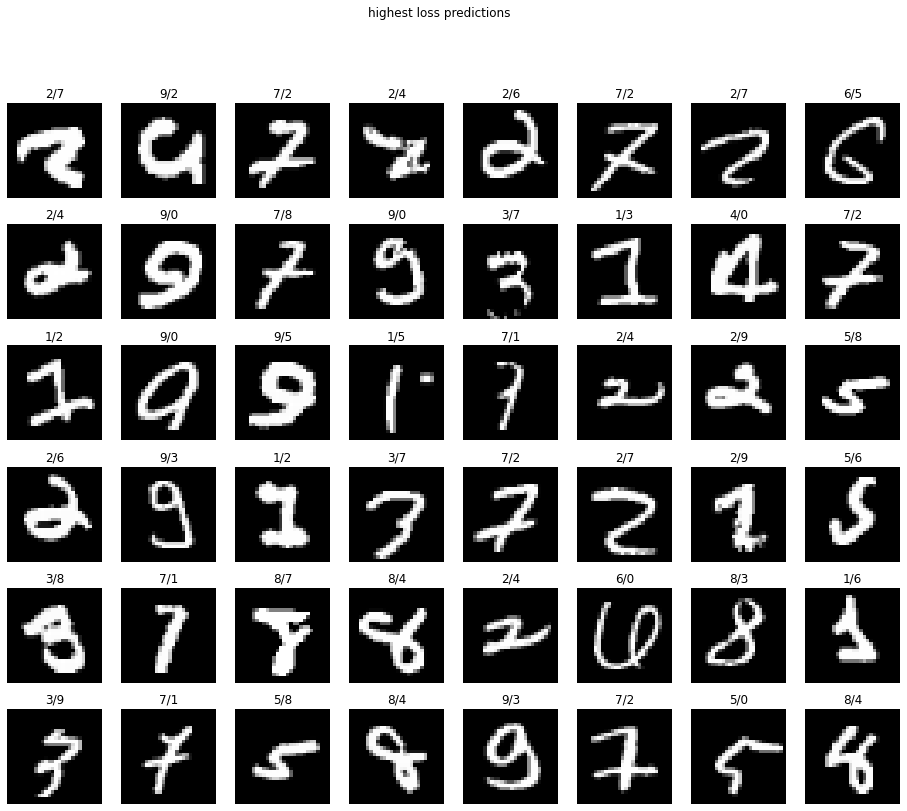

In [5]:
order = per_sample_loss.argsort(descending=True)
show_image_grid(X[order], y=y_true[order], y_pred=y_pred[order], title="highest loss predictions", nrow=8, ncol=6)

## Lets take a look inside

Since our model is so simple, we can actually take a look at the learned parameters of the network, as the weight matrix is just a stack of vectorized 28x28 images itself. Basically, we have trained 10 linear digit detectors. Lets have a look:

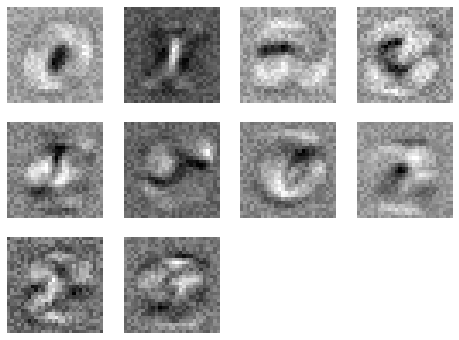

In [6]:
W = weight.detach()
show_image_grid(W.reshape(28, 28, 10).permute(2, 0, 1), nrow=4)

# Your Next Tasks

- Build a Multi-Layer-Perceptron (MLP) class using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
    - use [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) as first layer
    - use 2 or more [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layers
    - use `nn.ReLU` as activation between those layers
    - do you also need the `nn.ReLU` after the last layer?
    - decide how how many hidden layer neurons you want to use at each layer

- Build a CNN and reproduce the following architecture:
![alt text](https://www.easy-tensorflow.com/images/cnntext.png)
  - In the image above, k is the kernel size, F is the number of output channels, s is the stride, and FC means fully-connected layer (`nn.Linear`)
  - You will only need these modules: `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, `nn.Flatten`, `nn.Linear`

- Compare our previous shallow network, the MLP and the CNN by their validation accuracies
- Bonus tasks:
  - add `nn.BatchNorm2D` layers between conv & relu in your CNN and compare the loss curves
  - run your network on the gpu (use `.cuda()` to move both your network and your batches onto the GPU)
  - try the `AdamW` optimizer with weight decay